In [1]:
import numpy as np
import pandas as pd
from numpy import array
from random import randint
from sklearn.utils import shuffle
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, LSTM
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
%matplotlib inline
from sklearn.metrics import confusion_matrix
import itertools
import matplotlib.pyplot as plt
import seaborn as sns

In [6]:
#process data
#read from csv
df=pd.read_csv('data/univariate/kenya/ken_brt_lstm.csv')
label = 'Birth Rate'
title = 'Birth Rate crude(per 1000 people)'

print('Birth Rate dataset: ')
print(df.head(5))
print('shape: ',df.shape)

Birth Rate dataset: 
   year   value
0  1960  51.156
1  1961  51.068
2  1962  50.976
3  1963  50.887
4  1964  50.807
shape:  (60, 2)


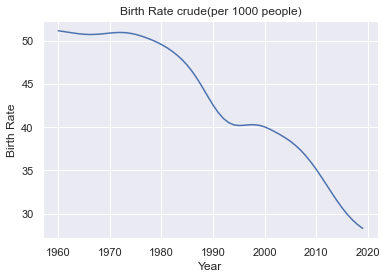

In [53]:
#visualize csv data
plt.plot(df['year'],df['value'])
plt.xlabel('Year')
plt.ylabel(label)
plt.title(title)
plt.show()

            ----------------------Data Preparation----------------------

In [7]:
#separate data into training and test datasets as arrays
training_set = df.iloc[:40, 1:2].values
test_set = df.iloc[40:, 1:2].values
test_years=df.loc[43:68, 'year'].values
test_years = np.reshape(test_years, (17,1))

#sliding window used in spliting the sequence
lag = 3 

#features
n_features = 1


In [8]:
#split the data set into time steps that predict the next step: X for samples, y for labels (actual output)

def split_sequence(sequence, lag):
    print(len(sequence))
    x, y = list(), list()
    for i in range(len(sequence)):
        # find the end of this pattern
        end_ix = i + lag
        # check if we are beyond the sequence
        if end_ix > len(sequence)-1:
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        x.append(seq_x)
        y.append(seq_y)
    return array(x), array(y)

In [12]:
#prepare the data for training
#split into samples and labels
x, y = split_sequence(training_set, lag)
print('Training samples: ')
print('shape: ',x.shape)
print(x)

40
Training samples: 
shape:  (37, 3, 1)
[[[51.156]
  [51.068]
  [50.976]]

 [[51.068]
  [50.976]
  [50.887]]

 [[50.976]
  [50.887]
  [50.807]]

 [[50.887]
  [50.807]
  [50.748]]

 [[50.807]
  [50.748]
  [50.723]]

 [[50.748]
  [50.723]
  [50.731]]

 [[50.723]
  [50.731]
  [50.768]]

 [[50.731]
  [50.768]
  [50.825]]

 [[50.768]
  [50.825]
  [50.887]]

 [[50.825]
  [50.887]
  [50.938]]

 [[50.887]
  [50.938]
  [50.958]]

 [[50.938]
  [50.958]
  [50.935]]

 [[50.958]
  [50.935]
  [50.859]]

 [[50.935]
  [50.859]
  [50.732]]

 [[50.859]
  [50.732]
  [50.56 ]]

 [[50.732]
  [50.56 ]
  [50.356]]

 [[50.56 ]
  [50.356]
  [50.125]]

 [[50.356]
  [50.125]
  [49.863]]

 [[50.125]
  [49.863]
  [49.564]]

 [[49.863]
  [49.564]
  [49.219]]

 [[49.564]
  [49.219]
  [48.817]]

 [[49.219]
  [48.817]
  [48.349]]

 [[48.817]
  [48.349]
  [47.808]]

 [[48.349]
  [47.808]
  [47.171]]

 [[47.808]
  [47.171]
  [46.409]]

 [[47.171]
  [46.409]
  [45.529]]

 [[46.409]
  [45.529]
  [44.56 ]]

 [[45.529]
  [

In [14]:
#Prep the test data
x_test, y_test = split_sequence(test_set, lag)
print('Test samples: ')
print('shape: ',x.shape)
print(x)

20
Test samples: 
shape:  (37, 3, 1)
[[[51.156]
  [51.068]
  [50.976]]

 [[51.068]
  [50.976]
  [50.887]]

 [[50.976]
  [50.887]
  [50.807]]

 [[50.887]
  [50.807]
  [50.748]]

 [[50.807]
  [50.748]
  [50.723]]

 [[50.748]
  [50.723]
  [50.731]]

 [[50.723]
  [50.731]
  [50.768]]

 [[50.731]
  [50.768]
  [50.825]]

 [[50.768]
  [50.825]
  [50.887]]

 [[50.825]
  [50.887]
  [50.938]]

 [[50.887]
  [50.938]
  [50.958]]

 [[50.938]
  [50.958]
  [50.935]]

 [[50.958]
  [50.935]
  [50.859]]

 [[50.935]
  [50.859]
  [50.732]]

 [[50.859]
  [50.732]
  [50.56 ]]

 [[50.732]
  [50.56 ]
  [50.356]]

 [[50.56 ]
  [50.356]
  [50.125]]

 [[50.356]
  [50.125]
  [49.863]]

 [[50.125]
  [49.863]
  [49.564]]

 [[49.863]
  [49.564]
  [49.219]]

 [[49.564]
  [49.219]
  [48.817]]

 [[49.219]
  [48.817]
  [48.349]]

 [[48.817]
  [48.349]
  [47.808]]

 [[48.349]
  [47.808]
  [47.171]]

 [[47.808]
  [47.171]
  [46.409]]

 [[47.171]
  [46.409]
  [45.529]]

 [[46.409]
  [45.529]
  [44.56 ]]

 [[45.529]
  [44.5

---------------------Hyperparameter Tuning-------------

In [61]:
#select possible parameters combination using grid search
from sklearn.model_selection import ParameterGrid

param_grid = {  
    'n_epoch': [20,50,100],
    'n_units': [40,50,60],
    'n_timesteps':(1,2,3)
}


grid = ParameterGrid(param_grid)
cnt = 0
for p in grid:
    cnt = cnt+1

print('Total Possible Models',cnt)


Total Possible Models 27


In [62]:
#use MAPE to determine the combination with the lowest error
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [33]:
model_parameters = pd.DataFrame(columns = ['MAPE','Parameters'])
for p in grid:
    test = pd.DataFrame()
    print(p)

    g_model = Sequential([
        LSTM(units=p['n_units'], input_shape=(p['n_timesteps'], n_features), activation='relu',return_sequences=True),
        LSTM(p['n_units'], activation='relu',return_sequences=True),
        LSTM(p['n_units'], activation='relu'),
        Dense(units=1)
    ])
    #compile the model
    g_model.compile(optimizer=Adam(learning_rate=0.01), loss='mse', metrics=['accuracy'])
    
    #train the model
    g_model.fit(x, y, batch_size=1, validation_split=0.1, epochs=p['n_epoch'], verbose=2)

    #Predict
    g_predictions = g_model.predict(x_test, batch_size = 1, verbose = 2)
    
    mape = mean_absolute_percentage_error(df['value'],g_predictions)
    print('Mean Absolute Percentage Error(MAPE)-------------------',mape)
    model_parameters = model_parameters.append({'MAPE':MAPE,'Parameters':p},ignore_index=True)

{'n_epoch': 20, 'n_timesteps': 1, 'n_units': 40}
Epoch 1/20
33/33 - 2s - loss: 642.1529 - accuracy: 0.0000e+00 - val_loss: 32.0570 - val_accuracy: 0.0000e+00
Epoch 2/20
33/33 - 0s - loss: 5.5349 - accuracy: 0.0000e+00 - val_loss: 3.9036 - val_accuracy: 0.0000e+00
Epoch 3/20
33/33 - 0s - loss: 1.4614 - accuracy: 0.0000e+00 - val_loss: 1.3409 - val_accuracy: 0.0000e+00
Epoch 4/20
33/33 - 0s - loss: 0.9729 - accuracy: 0.0000e+00 - val_loss: 1.4245 - val_accuracy: 0.0000e+00
Epoch 5/20
33/33 - 0s - loss: 0.9822 - accuracy: 0.0000e+00 - val_loss: 0.0706 - val_accuracy: 0.0000e+00
Epoch 6/20
33/33 - 0s - loss: 1.3014 - accuracy: 0.0000e+00 - val_loss: 3.6452 - val_accuracy: 0.0000e+00
Epoch 7/20
33/33 - 0s - loss: 1.7164 - accuracy: 0.0000e+00 - val_loss: 0.0522 - val_accuracy: 0.0000e+00
Epoch 8/20
33/33 - 0s - loss: 1.6648 - accuracy: 0.0000e+00 - val_loss: 0.0570 - val_accuracy: 0.0000e+00
Epoch 9/20
33/33 - 0s - loss: 1.5577 - accuracy: 0.0000e+00 - val_loss: 1.0428 - val_accuracy: 0.000

In [63]:
parameters = model_parameters.sort_values(by=['MAPE'])
parameters = parameters.reset_index(drop=True)
parameters.head()
parameters['Parameters'][0]

{'n_epoch': 100, 'n_timesteps': 2, 'n_units': 40}

In [39]:
n_model = Sequential([
        LSTM(units=40, input_shape=(2, n_features), activation='relu',return_sequences=True),
        LSTM(40, activation='relu',return_sequences=True),
        LSTM(40, activation='relu'),
        Dense(units=1)
    ])
n_model.summary()

Model: "sequential_30"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_90 (LSTM)               (None, 2, 40)             6720      
_________________________________________________________________
lstm_91 (LSTM)               (None, 2, 40)             12960     
_________________________________________________________________
lstm_92 (LSTM)               (None, 40)                12960     
_________________________________________________________________
dense_30 (Dense)             (None, 1)                 41        
Total params: 32,681
Trainable params: 32,681
Non-trainable params: 0
_________________________________________________________________


In [67]:
#compile the model
n_model.compile(optimizer=Adam(learning_rate=0.01), loss='mse', metrics=['accuracy'])

#train the model
n_model.fit(x, y, batch_size=1, validation_split=0.1, epochs=100, verbose=2)

#Predict
n_predictions = n_model.predict(x_test, batch_size = 1, verbose = 2)
n_predictions

Epoch 1/100
33/33 - 2s - loss: 23.6853 - accuracy: 0.0000e+00 - val_loss: 1.9349 - val_accuracy: 0.0000e+00
Epoch 2/100
33/33 - 0s - loss: 1.0509 - accuracy: 0.0000e+00 - val_loss: 1.2928 - val_accuracy: 0.0000e+00
Epoch 3/100
33/33 - 0s - loss: 1.8070 - accuracy: 0.0000e+00 - val_loss: 2.6821 - val_accuracy: 0.0000e+00
Epoch 4/100
33/33 - 0s - loss: 2.3812 - accuracy: 0.0000e+00 - val_loss: 0.1114 - val_accuracy: 0.0000e+00
Epoch 5/100
33/33 - 0s - loss: 1.7705 - accuracy: 0.0000e+00 - val_loss: 6.6292 - val_accuracy: 0.0000e+00
Epoch 6/100
33/33 - 0s - loss: 2.7155 - accuracy: 0.0000e+00 - val_loss: 0.6640 - val_accuracy: 0.0000e+00
Epoch 7/100
33/33 - 0s - loss: 1.4807 - accuracy: 0.0000e+00 - val_loss: 0.1266 - val_accuracy: 0.0000e+00
Epoch 8/100
33/33 - 0s - loss: 4.1885 - accuracy: 0.0000e+00 - val_loss: 0.0899 - val_accuracy: 0.0000e+00
Epoch 9/100
33/33 - 0s - loss: 1.2269 - accuracy: 0.0000e+00 - val_loss: 1.6423 - val_accuracy: 0.0000e+00
Epoch 10/100
33/33 - 0s - loss: 1.02

array([[38.415234],
       [38.085285],
       [37.710808],
       [37.302956],
       [36.8487  ],
       [36.326416],
       [35.713604],
       [34.998272],
       [34.178432],
       [33.262108],
       [32.260612],
       [31.196339],
       [30.103352],
       [29.018602],
       [27.976715],
       [27.013567],
       [26.154787]], dtype=float32)

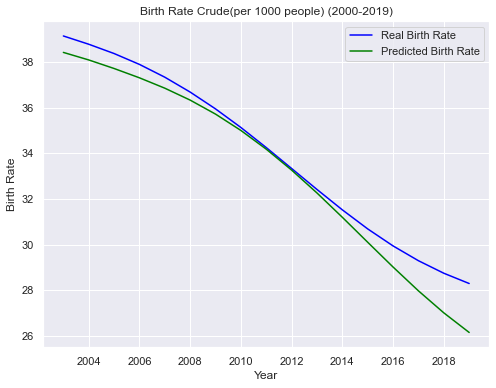

In [71]:
# Visualising the results
plt.plot(test_years,y_test, color = 'blue', label = 'Real Birth Rate')
plt.plot(test_years,n_predictions, color = 'green', label = 'Predicted Birth Rate')
plt.legend()
plt.xlabel('Year')
plt.ylabel(label)
plt.title('Birth Rate Crude(per 1000 people) (2000-2019)')
plt.show()
sns.set(rc={'figure.figsize':(8,6)})

In [69]:
# report performance
from math import sqrt
from sklearn.metrics import mean_squared_error
rmse = sqrt(mean_squared_error(y_test, n_predictions))
print(' Test RMSE: %.3f' %  rmse)

 Test RMSE: 0.870


 ----------- To Do: Predict the next 10 years